In [5]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Dataset

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_mcs_mouth.xml')

In [6]:
def extract_data(path,create_test=None):
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]

    file=os.listdir(path)

    for entity in file:
        try:
            entityPath=os.listdir(f"{path}/{entity}")
            for i,data in enumerate(entityPath):
                try:
                    current_img=cv2.imread(f"{path}/{entity}/{data}")
                    if current_img is not None:
                        if (create_test is not None and ((len(entityPath)>1) and (i==0))):
                            X_test.append(current_img)
                            y_test.append(entity)
                        else:
                            X_train.append(current_img)
                            y_train.append(entity)
                    else:
                        print(f"{path}/{entity}/{data} is None type")
                except Exception as e:
                    print(f"Erreur avec {path}/{entity}/{data} : {e}")
        except Exception as ex:
            print(f"Erreur avec {path}/{entity} : {ex}")
    
    print(f"Number of training sample : {len(X_train)}\n")
    if create_test is not None:
        print(f"Number of test sample : {len(X_test)}\n")
        return X_train,y_train,X_test,y_test
    else:
        return X_train,y_train

In [7]:
def extract_face_and_eyes(img):
    if not isinstance(img,np.ndarray):
        img=cv2.imread(img)

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(60,60)
    )

    if len(faces)==0:
        return [],[]
    else:
        trueFaces=[]
        trueEyes=[]
        for i,face in enumerate(faces):
            x,y,w,h=face
            imgFace=img[y:y+h,x:x+w]
            eyes=eye_cascade.detectMultiScale(imgFace)
            if len(eyes)>=2:
                trueFaces.append(face)
                if eyes[0][0]<eyes[1][0]:
                    x2=eyes[0][0]
                    w2=eyes[1][0]+eyes[1][2]-x2
                else:
                    x2=eyes[1][0]
                    w2=eyes[0][0]+eyes[0][2]-x2
                if eyes[0][1]<eyes[1][1]:
                    y2=eyes[0][1]
                    h2=eyes[1][1]+eyes[1][3]-y2
                else:
                    y2=eyes[1][1]
                    h2=eyes[0][1]+eyes[0][3]-y2
                trueEyes.append((x2+x,y2+y,w2,h2))
        return trueFaces,trueEyes
    

In [8]:
def extract_face(img):
    if not isinstance(img,np.ndarray):
        img=cv2.imread(img) #si on passe un path ça read l'img

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(60,60)
    )

    if len(faces)==0:
        return img #retourne l'img si aucun visage n'est detecté
    
    #si je veux detecter tous les visages présents je dois faire une boucle for x,y,w,h in faces: et return une liste d'img crops
    x,y,w,h=faces[0] #faces retourne n tuples (x,y,h,w) correspondants aux coords du visage
    face=img[y:y+h,x:x+w] #retourne l'img crop aux coords detectées
    return face

In [15]:
transform_face_test=transforms.Compose([
    transforms.ToPILImage(), #transforme en format PIL
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100,100)),
    transforms.ToTensor() #reconvertit l'img en format tensor
])

transform_face=transforms.Compose([
    transforms.ToPILImage(), #transforme en format PIL
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100,100)),
    transforms.RandomHorizontalFlip(), #0.5 de proba d'inverser la gauche et la droite de l'img pour rendre le modèle invariant à la symétrie
    transforms.RandomRotation(15), #applique rota random entre -10° et +10° 
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.2,hue=0.02), #altère aléatoirement la luminosité et le contraste de l'image
    transforms.ToTensor() #reconvertit l'img en format tensor
])

In [10]:
class FaceEyesDataset(Dataset):
    def __init__(self, X, y, labels, transform_face):
        self.X = X  # Liste des chemins ou images
        self.y = [labels[label] for label in y]  # Labels convertis en indices
        self.transform_face = transform_face

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]

        if not isinstance(img, np.ndarray):
            img = cv2.imread(img)

        face=extract_face(img)

        if not isinstance(face, np.ndarray) or face.size == 0:
            face = np.zeros((100, 100, 3), dtype=np.uint8)

        face = self.transform_face(face)

        label = self.y[idx]
        return face, label

In [11]:
def resnetTrain(X_train,y_train,nb_epoch,labels,batch_size,patience=5,val_split=False):
    model=models.resnet50(pretrained=True)
    nb_classes=105
    model.fc=nn.Linear(model.fc.in_features,nb_classes)

    for param in model.parameters():
        param.requires_grad=False
    for param in model.fc.parameters():
        param.requires_grad=True

    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.fc.parameters(),lr=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if val_split:
        X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=1,stratify=y_train)
        val_dataset=FaceEyesDataset(X_val,y_val,labels,transform_face=transform_face_test)
        val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
        best_val_acc=0
        wait=0

    train_dataset=FaceEyesDataset(X_train,y_train,labels,transform_face=transform_face)
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    tabTrain=[]
    tabVal=[]
    for epoch in range(nb_epoch):
        model.train()

        total_loss=0.0
        correct=0
        total=0

        for face_batch,y_batch in train_loader:
            face_batch=face_batch.to(device)
            y_batch=y_batch.to(device)

            optimizer.zero_grad()

            outputs=model(face_batch)

            loss=criterion(outputs,y_batch)
            loss.backward()
            optimizer.step()

            total_loss+=loss.item()
            _,predicted=torch.max(outputs,1)
            correct+=(predicted==y_batch).sum().item()
            total+=y_batch.size(0)
        
        acc=100*correct/total
        tabTrain.append(acc)
        print(f"\nEpoch : {epoch+1}/{nb_epoch}\n Perte :{total_loss:.4f}\n Accuracy : {acc:.2f}%")

        if val_split:
            true,false,tot=resnetEval(model,loader=val_loader,labels=labels,graph=False)
            val_acc=sum(true.values())/sum(tot.values())
            tabVal.append(100*val_acc)
            if val_acc>best_val_acc:
                best_val_acc=val_acc #si l'acc de la val est meilleure on l'assigne et on reset le timer 
                wait=0
                best_model_faces=copy.deepcopy(model.state_dict())
            else:
                wait+=1
                if wait>=patience: #on attend le nombre d'epoch max sans amélioration
                    print("Early stopping activated")
                    break
            print(f"\n Val accuracy : {val_acc*100:.2f}%\n Série sans amélioration : {wait}")
    model.load_state_dict(best_model_faces)
        
    absc=list(range(len(tabTrain)))
    plt.figure(figsize=(8,5))
    plt.plot(absc,tabTrain,label="Training",marker="o")
    if val_split:
        plt.plot(absc,tabVal,label="Validation",marker="s")
    plt.xlim(1,len(tabTrain))
    plt.ylim(0,100)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    print("Training terminé.")
    plt.show()
    return model

In [12]:
def resnetEval(model,loader,labels,graph=False):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    labelF=defaultdict(int)
    labelC=defaultdict(int)
    labelT=defaultdict(int)

    with torch.no_grad():
        for faces_batch,y_batch in loader:
            faces_batch=faces_batch.to(device)
            y_batch=y_batch.to(device)

            outputs=model(faces_batch)

            _,pred=torch.max(outputs,1)
            for i in range(len(y_batch)):
                label=y_batch[i].item()
                pred[i]=pred[i].item()

                if pred[i]==label:
                    labelC[label]+=1
                else:
                    labelF[label]+=1
                labelT[label]+=1

    if graph:
        print(f"Total accuracy : {sum(labelC.values())/sum(labelT.values())*100:.2f}%")
        precisions={}
        for label in labelT:
            tot=labelT[label]
            correct=labelC.get(label,0)
            precisions[label]=correct/tot if tot>0 else 0
        prec_sorted=sorted(precisions.items(),key=lambda x: x[1])
        labels_ids,values= zip(*prec_sorted)

        id2label = {v: k for k, v in labels.items()}
        class_names=[id2label[i] for i in labels_ids]

        plt.figure(figsize=(12, 5))
        plt.bar(class_names, values, color='skyblue')
        plt.xticks(rotation=45)
        plt.ylabel("Accuracy par classe")
        plt.title("Performance du modèle par classe")
        plt.tight_layout()
        plt.show()
    
    return labelC,labelF,labelT

In [13]:
X_train,y_train=extract_data("DataFaces")
labels={label:i for i,label in enumerate(sorted(set(y_train)))}
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

Number of training sample : 17534



c:\Users\asami\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asami\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch : 1/50
 Perte :1597.1640
 Accuracy : 2.89%

 Val accuracy : 4.49%
 Série sans amélioration : 0

Epoch : 2/50
 Perte :1505.6021
 Accuracy : 6.95%

 Val accuracy : 10.41%
 Série sans amélioration : 0

Epoch : 3/50
 Perte :1442.4545
 Accuracy : 10.66%

 Val accuracy : 12.72%
 Série sans amélioration : 0

Epoch : 4/50
 Perte :1392.5693
 Accuracy : 13.32%

 Val accuracy : 13.83%
 Série sans amélioration : 0

Epoch : 5/50
 Perte :1355.3189
 Accuracy : 14.49%

 Val accuracy : 15.22%
 Série sans amélioration : 0

Epoch : 6/50
 Perte :1327.1969
 Accuracy : 15.33%

 Val accuracy : 16.25%
 Série sans amélioration : 0

Epoch : 7/50
 Perte :1299.0073
 Accuracy : 16.76%

 Val accuracy : 16.57%
 Série sans amélioration : 0

Epoch : 8/50
 Perte :1279.4820
 Accuracy : 17.90%

 Val accuracy : 17.21%
 Série sans amélioration : 0

Epoch : 9/50
 Perte :1258.3964
 Accuracy : 18.55%

 Val accuracy : 17.21%
 Série sans amélioration : 1

Epoch : 10/50
 Perte :1243.3934
 Accuracy : 18.79%

 Val accuracy 

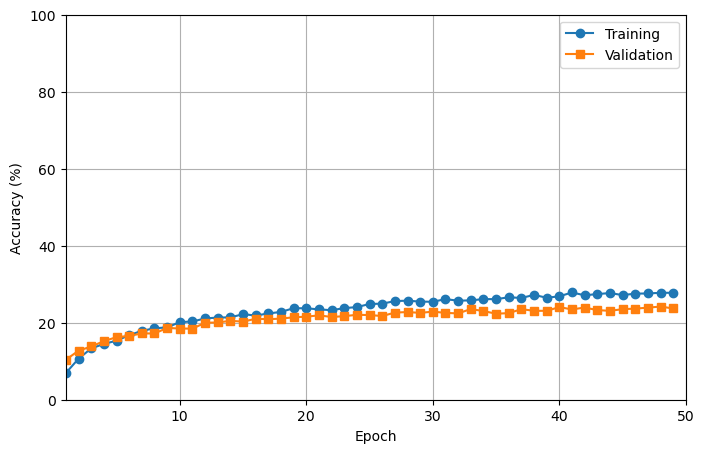

In [16]:
model=resnetTrain(X_train,y_train,nb_epoch=50,labels=labels,batch_size=32,patience=10,val_split=True)

In [ ]:
capture=cv2.VideoCapture(0,cv2.CAP_DSHOW)
u=0
path="TestPhotos"

if not capture.isOpened():
    print("Erreur : Impossible d'ouvrir la webcam")
else:
    while True:
        ret,frame=capture.read()

        if not ret:
            break

        #frame=cv2.rotate(frame,cv2.ROTATE_90_CLOCKWISE)
        faces,eyes=extract_face_and_eyes(frame)
        if len(faces)!=0:
            u+=1
            for i,face in enumerate(faces):
                x,y,w,h=face
                x2,y2,w2,h2=eyes[i]
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),3)
                cv2.rectangle(frame,(x2,y2),(x2+w2,y2+h2),(255,0,0),3)
                if u>=60:
                    u=0
                    file=os.listdir(path)
                    if f"{path}/photo-{len(file)}" not in file:
                        cv2.imwrite(f"{path}/photo-{len(file)}.jpg",frame[y:y+h,x:x+w])
                    print(f"Image enregistrée : {len(file)}")

        cv2.imshow("Webcam",frame)
        if cv2.waitKey(1) & 0xFF==ord("q"):
            break

capture.release()
cv2.destroyAllWindows()
print("Program exited")

18
Image enregistrée : 18
19
Image enregistrée : 19
20
Image enregistrée : 20
21
Image enregistrée : 21
22
Image enregistrée : 22
23
Image enregistrée : 23
24
Image enregistrée : 24
25
Image enregistrée : 25
26
Image enregistrée : 26
27
Image enregistrée : 27
28
Image enregistrée : 28
29
Image enregistrée : 29
30
Image enregistrée : 30
31
Image enregistrée : 31
32
Image enregistrée : 32
33
Image enregistrée : 33
34
Image enregistrée : 34
35
Image enregistrée : 35
36
Image enregistrée : 36
37
Image enregistrée : 37
38
Image enregistrée : 38
39
Image enregistrée : 39
40
Image enregistrée : 40
41
Image enregistrée : 41
42
Image enregistrée : 42
43
Image enregistrée : 43
44
Image enregistrée : 44
45
Image enregistrée : 45
46
Image enregistrée : 46
47
Image enregistrée : 47
48
Image enregistrée : 48
49
Image enregistrée : 49
50
Image enregistrée : 50
51
Image enregistrée : 51
52
Image enregistrée : 52
53
Image enregistrée : 53
54
Image enregistrée : 54
55
Image enregistrée : 55
56
Image enr